# A two-prey/one-predator system

This is like the Lotka-Volterra system, but now there are two prey species instead of one.

$$
\begin{split}
\frac{dV_1}{dt} & = r_1 V_1 - a_1 P V_1 \\
\frac{dV_2}{dt} & = r_2 V_2 - a_2 P V_2 \\
\frac{dP}{dt} & = P(e_1 a_1 V_1 + e_2 a_2 V_2) - g P 
\end{split}
$$

equilibria must satisfy:

$$
\begin{split}
P^* & = r_1/a_1 \text{ or } V_1^*=0 \\
P^* & = r_2/a_2 \text{ or } V_2^*=0 \\
e_1 a_1 V_1^* + e_2 a_2 V_2^* & = g \text{ or } P^*=0\\
\end{split}
$$

Conclusions: can't have three-way coexistence equilibrium in general (only works if $r_1/a_1=r_2/a_2$; we do have (0,0,0), but otherwise collapses to $(V_1^*,0,P_1^*)$ or $(V_2^*,0,P_2^*)$ (each of which looks like the corresponding Lotka-Volterra equilibrium, i.e.  $(V_i^*=g/(e_i a_i), V_j^*=0)$.

Stability? Jacobian is

$$
\left( \begin{array}{ccc}
r_1 - a_1 P & 0 & -a_1 V_1 \\
0             & r_2 - a_2 P & -a_2 V_2 \\
e_1 a_1 P & e_2 a_2 P & e_1 a_1 V_1 + e_2 a_2 V_2 - g 
\end{array}
\right)
$$

At the 0 equilibrium this is 

$$
\left( \begin{array}{ccc}
r_1  & 0 & 0 \\
0 & r_2 & 0 \\
0 & 0 & - g 
\end{array}
\right) \quad ,
$$
i.e. unstable as long as either $r_1>0$ or $r_2>0$.

Considering $(g/(e_1 a_1), 0, r_1/a_1)$ equilibrium:

$$
\left( \begin{array}{ccc}
0 & 0 & -g/e_1 \\
0 & r_2 -a_2 r_1/a_1 & 0 \\
e_1 r_1 & e_2 a_2 r_1/a_1 & 0
\end{array}
\right)
$$

This is unstable if $a_1 r_2 > a_2 r_1$, but as we'll see, it's *not* stable if the reverse is true, because there are also a couple of pure-imaginary eigenvalues.  Being lazy and doing the symbolic linear algebra with Python:

In [60]:
from sympy import *
a1,a2,r1,r2,e1,e2,g = symbols("a1 a2 r1 r2 e1 e2 g")  ## define symbols
J1 = Matrix([[0,0,-g/e1],[0,r2-a2*r1/a1,0],[e1*r1,e2*a2*r1/a1,0]])  ## set up the matrix
J1.eigenvals()  ## answer gives eigenvalue and multiplicity

{sqrt(-g*r1): 1, -sqrt(-g*r1): 1, -(-a1*r2 + a2*r1)/a1: 1}

Check numerically:

In [61]:
import numpy as np
params = (1,1,1,0.5,0.2,1,0.5)
def jac1(params):
    a1, a2, r1, r2, e1, e2, g = params
    J = np.array([[0,0,-g/e1],[0,r2-a2*r1/a1,0],[e1*r1,e2*a2*r1/a1,0]])
    return(np.linalg.eigvals(J))
jac1(params)

array([ 0.0+0.70710678j,  0.0-0.70710678j, -0.5+0.j        ])

In [56]:
def jac2(params):
    a1, a2, r1, r2, e1, e2, g = params
    J = np.array([[r1-a1*r2/a2,0,0],[0,0,-g/e2],[e1*a1*r2/a2,e2*r2,0]])
    return(np.linalg.eigvals(J))
jac2(params)

array([ 0.0+0.5j,  0.0-0.5j,  0.5+0.j ])

In [54]:
import matplotlib.pyplot as plt
import scipy.integrate
def gradfun(x,t,params):
    V1, V2, P = x
    a1, a2, r1, r2, e1, e2, g = params
    return(np.array([r1*V1-a1*V1*P,
                     r2*V2-a2*V2*P,
                     P*(e1*a1*V1+e2*a2*V2)-g*P]))

tvec = np.linspace(0,100,1001)
s_val = scipy.integrate.odeint(
    gradfun,
    y0 = (0.2,0.9,0.4),  ## starting value is a tuple
    t = tvec,
    args = (params,))

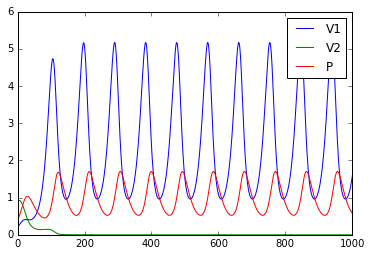

In [51]:
%matplotlib inline
plt.plot(s_val);
plt.legend(["V1","V2","P"]);
plt.axhline(c="black");

Can do a 3D plot if we want ...

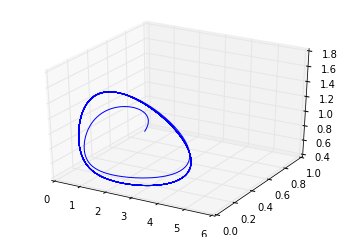

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d as mp3d
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d') 
plt.plot(s_val[:,0],s_val[:,1],s_val[:,2]);

If we want to go crazy we can add sinusoidal forcing to the predator death rate with period $\tau$: we'll use $1+\sin(2 \pi t/\tau)$ so that the predator death rate doesn't become negative ...

$$
\begin{split}
\frac{dV_1}{dt} & = r_1 V_1 - a_1 P V_1 \\
\frac{dV_2}{dt} & = r_2 V_2 - a_2 P V_2 \\
\frac{dP}{dt} & = P(e_1 a_1 V_1 + e_2 a_2 V_2) - g P (1+\sin(2 \pi t/\tau))
\end{split}
$$

In [84]:
def gradfun_forced(x,t,params):
    V1, V2, P = x
    a1, a2, r1, r2, e1, e2, g, tau = params
    return(np.array([r1*V1-a1*V1*P,
                     r2*V2-a2*V2*P,
                     P*(e1*a1*V1+e2*a2*V2)-g*P*(1+np.sin(2*np.pi*t/tau))]))
params2 = params+(10,)  ## add tau=2 to the end of the parameter vector


In [85]:
s_val_forced = scipy.integrate.odeint(
    gradfun_forced,
    y0 = (0.2,0.9,0.4),  ## starting value is a tuple
    t = tvec,
    args = (params2,))

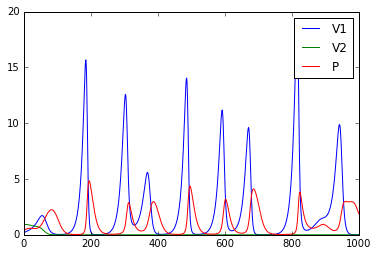

In [87]:
%matplotlib inline
plt.plot(s_val_forced);
plt.legend(["V1","V2","P"]);

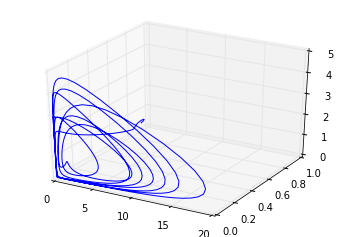

In [88]:
%matplotlib inline
fig = plt.figure()
ax = fig.gca(projection='3d') 
plt.plot(s_val_forced[:,0],s_val_forced[:,1],s_val_forced[:,2]);